# MCE vs. Logistic Regression

## By: Mustafa Yildirim

### Implementing minimum classification error (MCE) method to learn a binary classifier to classify two digits ('7' vs. '9') in the MNIST dataset and comparing its performance with that of logistic regression.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#load MINST images
from mnist import MNIST

In [ ]:
mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape)

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# Prepare digits '7' and '9' for logistic regression
digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# Add a constant column of '1' to accommodate the bias
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# Convert labels: '7' => -1, '9' => +1
CUTOFF = 8  # Any number between '7' and '9'
y_train = np.sign(y_train - CUTOFF)
y_test = np.sign(y_test - CUTOFF)

MCE implementation

In [ ]:
class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs


# sigmoid for numpy arrays
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# X[N,d]: training features; y[N]: training targets;
# X2[N,d]: test features; y2[N]: test targets;
# op: hyper-parameters for optimzer

def mce_gd(X, y, X2, y2, op):
  n = X.shape[0]            # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  # randomly shuffle data indices

    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # MCE Gradient Calculation
      w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) * (1 - sigmoid(y_batch * (X_batch @ w)))) / X_batch.shape[0]

      w -= lr * w_grad

    # For learning curve C (MCE loss)
    errorsC[epoch] = np.mean(sigmoid(-y * (X @ w)))

    # For learning curve A (training accuracy)
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size

    # For learning curve B (test accuracy)
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate

  print(f'Epoch {epoch}: MCE Loss = {errorsC[epoch]:.3f} (A={errorsA[epoch]:.3f},B={errorsB[epoch]:.3f})')
  return w, errorsA, errorsB, errorsC

Output figure of MCE

Epoch 49: MCE Loss = 0.946 (A=0.043,B=0.037)


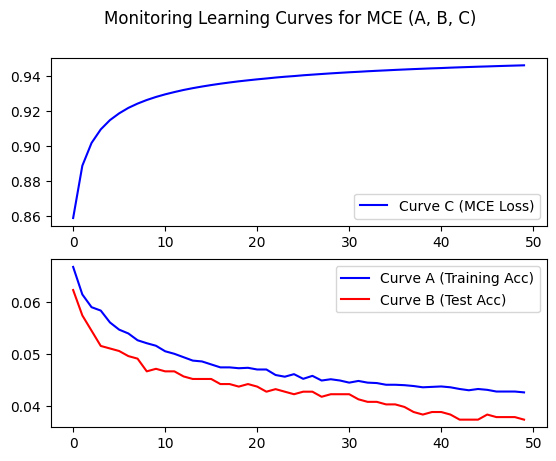

In [ ]:
op = Optimizer(lr=0.02, annealing_rate=0.99, batch_size=20, max_epochs=50)

w_mce, A_mce, B_mce, C_mce = mce_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('Monitoring Learning Curves for MCE (A, B, C)')
ax[0].plot(C_mce, 'b')
ax[0].legend(['Curve C (MCE Loss)'])

ax[1].plot(A_mce, 'b', B_mce, 'r')
ax[1].legend(['Curve A (Training Acc)', 'Curve B (Test Acc)'])
plt.show()

doing 1 - P

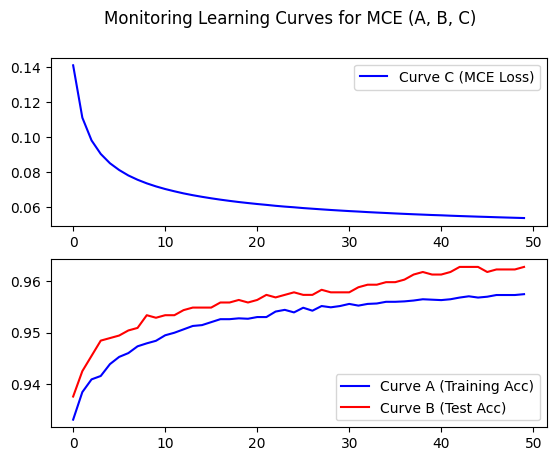

In [ ]:
w = 1 - w_mce
A = 1 - A_mce
B = 1 - B_mce
C = 1 - C_mce

fig, ax = plt.subplots(2)
fig.suptitle('Monitoring Learning Curves for MCE (A, B, C)')
ax[0].plot(C, 'b')
ax[0].legend(['Curve C (MCE Loss)'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['Curve A (Training Acc)', 'Curve B (Test Acc)'])
plt.show()

Logistic Regression from Lab3 Jupyter Notebook

In [ ]:
class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# sigmoid for numpy arrays
def sigmoid(x):
  return 1/(1 + np.exp(-x))

# X[N,d]: training features; y[N]: training targets;
# X2[N,d]: test features; y2[N]: test targets;
# op: hyper-parameters for optimzer
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def logistic_regression_gd(X, y, X2, y2, op):
  n = X.shape[0]            # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) - y_batch) / X_batch.shape[0]

      w -= lr * w_grad

    # for learning curve C
    errorsC[epoch]  = - np.mean(np.log( sigmoid(y * (X @ w))) )  # logisic regression loss function
                                                                 # see the above formula
    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate

  print(f'epoch={epoch}: the logistic regression loss is C={errorsC[epoch]:.3f} (A={errorsA[epoch]:.3f},B={errorsB[epoch]:.3f})')
  return w, errorsA, errorsB, errorsC

Output

epoch=49: the logistic regression loss is C=0.112 (A=0.962,B=0.964)


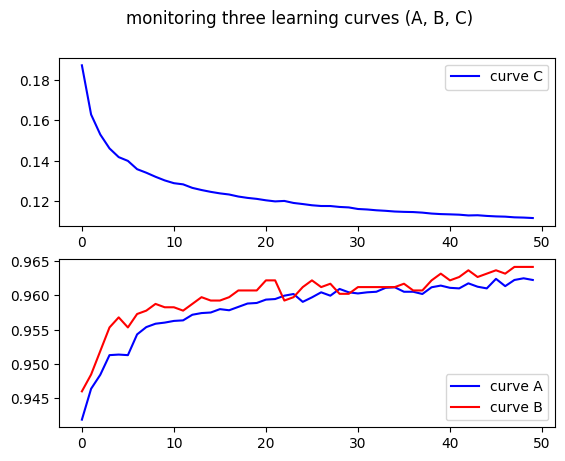

In [ ]:
op = Optimizer(lr=0.02, annealing_rate=0.99, batch_size=20, max_epochs=50)

w_lr, A_lr, B_lr, C_lr = logistic_regression_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C_lr, 'b')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A_lr, 'b', B_lr, 'r')
ax[1].legend(['curve A', 'curve B'])

Logistic Regression from sklearn

In [ ]:
# use logistic regression from sklearn

from sklearn.linear_model import LogisticRegression

# create a logistic regression model
log_reg = LogisticRegression(max_iter=10000)

# training: fit the training data
log_reg.fit(X_train,y_train)

log_reg_test_accuracy = log_reg.score(X_train,y_train)

# measure the training accuracy
print(f'training accuracy: {log_reg_test_accuracy}')

# predit the test data
predict = log_reg.predict(X_test)

print(f'test accuracy: {log_reg.score(X_test,y_test)}')

training accuracy: 0.9714262321925659
test accuracy: 0.9680903289150712


Comparing the performance of MCE with that of logistic regression and reporting the best results in the heldout test data of these two digits.

MCE vs Logistic regression Lab implementation

In [ ]:
mce_test_accuracy = B[-1]
print(f'MCE Test Accuracy: {mce_test_accuracy * 100:.2f}%')

MCE Test Accuracy: 96.27%


In [ ]:
lr_test_accuracy = B_lr[-1]
print(f'LR Test Accuracy: {lr_test_accuracy * 100:.2f}%')

LR Test Accuracy: 96.42%


In [ ]:
if mce_test_accuracy > lr_test_accuracy:
  print("MCE model performed better")
else:
  print("Logistic Regression model performed better")

Logistic Regression model performed better


MCE vs Logistic regression sklearn implementation

In [ ]:
if mce_test_accuracy > log_reg_test_accuracy:
  print("MCE model performed better")
else:
  print("Logistic Regression model performed better")

Logistic Regression model performed better
